In [6]:
import numpy as np
import os
from os.path import join as pjoin
from glob import iglob
import json
from shutil import copyfile

In [7]:
root_path = '/data/ksb'
bert_root = pjoin(root_path, 'BertSum/kor_PreSumm')
kobart_root = pjoin(root_path, 'BART/KoBART-summarization')
refsum_root = pjoin(root_path, 'RefSum/Refactoring-Summarization')

In [8]:
data_root = pjoin(root_path, 'korean_paper')

In [9]:
kobert_root = pjoin(root_path, 'BertSum/koBertSum')
kobert_data = pjoin(kobert_root, 'kopaper_raw_stories')
kobert_data

'/data/ksb/BertSum/koBertSum/kopaper_raw_stories'

In [10]:
def mkdir_p(path):
    import errno
    try:
        os.makedirs(path)
    except OSError as err:
        if err.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
            
def del_folder(path):
    try:
        rmtree(path)
    except:
        pass

In [11]:
import re

splitter = re.compile('([.!?-](?:["\']|(?![0-9])))')

def split_doc(doc_txt):
    def is_splited_sentence(sentences):
            return len(sentences) > 1
        
    docs = splitter.split(doc_txt)
    
    if not is_splited_sentence(docs): 
        yield docs[0]
    else :
        for s in map(lambda a, b: a + b, docs[::2], docs[1::2]):
            if not s: continue
            yield s[1:] if s.startswith(' ') else s

In [12]:
def get_paper_list(reg_exp):
    
    paper_list = []
    
    for path in iglob(reg_exp, recursive=False):
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            for paper in data['data']:
                idx = paper['reg_no']

                entire_paper = paper['summary_entire'][0]
               
                content = entire_paper['orginal_text']
                content = list(split_doc(content))
                abs_summ = entire_paper['summary_text']
                abs_summ = list(split_doc(abs_summ))
                
                paper_dic = (idx, content, abs_summ)
                paper_list.append(paper_dic)
        
    return paper_list
    

In [13]:
import jsonlines

train_data = pjoin(data_root, 'train_paper_*.json')
val_data = pjoin(data_root,'valid_paper_*.json')

train_paper_list = get_paper_list(train_data)
val_paper_list = get_paper_list(val_data)

(len(train_paper_list), len(val_paper_list))

(144280, 18061)

### BERT Extractor

### korBART Finetuning data


In [14]:
def copy_file(src_regex, dst_path):
    for src in iglob(src_regex, recursive=False):
        copyfile(src, dst_path)

In [15]:
kor_bart_data_dir = pjoin(kobart_root, 'paper_data')

train_data_path = pjoin(kor_bart_data_dir, 'train.tsv')
test_data_path = pjoin(kor_bart_data_dir, 'test.tsv')

In [16]:
train_paper_list[0][1]

['본 연구는 경제협력개발기구(Organization for Economic Cooperation and Development, OECD)가 실시한 교수-',
 '학습 국제조사(Teaching and Learning International Survey 2013, TALIS) 중 교직 선택에 대한 교사 후회에 관한조사를 연구의 출발점으로 삼았다.',
 '한국의 경우 중학교 교사가 참여한 이 조사에서 응답 교사의 20.1%가 교사가 된 것을 후회한다는 결과가 나오자 사회적 관심이 집중되었다.',
 '교직 선택을 후회하는 교사 비율은 조사대상국 중 최고로 높은 수치로 이는 곧 교사의 낮은 사기와 만족도를 표현하는 것으로 해석되었고 교원 정책에 대한 비판의 근거로 제시되었다.',
 '이 연구는 교사가 경험하는 후회의 감정은 매우 복잡한 현상이고 다양한 변인이 작용하는 심리적메커니즘을 가지고 있다는 선행연구에 기초하여 이러한 단순한 해석이 갖는위험을 지적하고 탐색적인 차원에서 대안적인 해석의 가능성을 제시하였다.',
 '기회(대안)와 후회, 정상(norm)과 후회, 후회의 기능이라는 3가지 영역을검토하면서, 교사 후회 현상은 다양한 변인의 영향을 받을 수 있음을 지적하고 관련 정책적 시사점도 아울러 모색하였다.',
 '특히, 교사 후회는 교직 선택동기에 관한 연구, 교직을 선택한 시기에 관한 조사, 교직 선택이 당연한 집단이 가진 특성, 후회를 감소시키기 위한 교사의 교직 행동 등과 관련지어새롭게 해석될 수 있음을 보여주었다.',
 '앞으로 후회 감정에 관련된 심리적 비교에서 고려되는 요소, 행위/비행위 사이 차이, 후회에 관련된 심리적 처리의휴리스틱과 편향 등 후속 연구가 적절히 이루어질 때 교사 후회 현상에 대한제대로 된 해석이 가능하고, 교사 후회 현상을 바탕으로 한 정책 개발 및 평가도 타당하게 이루어질 수 있을 것이다.']

In [17]:
from kobart import get_kobart_tokenizer
kobart_tokenizer = get_kobart_tokenizer()

train_dataset = []
for data in train_paper_list:
    paper_id = data[0]
    content = data[1]
    summary = data[2]
    
    paper_txt = ' '.join(content)
    summ_txt = ' '.join(summary)
    
    paper_token = kobart_tokenizer.tokenize(paper_txt)
    summary_token = kobart_tokenizer.tokenize(summ_txt)
    
    train_dataset.append((paper_id, content, summary, paper_token, summary_token))


using cached model


In [18]:
kobart_tokenizer = get_kobart_tokenizer()

val_dataset = []
for data in val_paper_list:
    paper_id = data[0]
    content = data[1]
    summary = data[2]
    
    paper_txt = ' '.join(content)
    summ_txt = ' '.join(summary)
    
    paper_token = kobart_tokenizer.tokenize(paper_txt)
    summary_token = kobart_tokenizer.tokenize(summ_txt)

    val_dataset.append((paper_id, content, summary, paper_token, summary_token))

len(val_dataset)

using cached model


18061

In [19]:
(len(train_dataset), len(val_dataset))

(144280, 18061)

In [20]:
dataset = train_dataset + val_dataset
len(dataset)

162341

In [21]:
paper_token_dist = [len(data[-2]) for data in dataset]
summary_token_dist = [len(data[-1]) for data in dataset]

In [22]:
paper_token_dist[0]

367

In [30]:
dataset[0]

('ART002387022',
 ['본 연구는 경제협력개발기구(Organization for Economic Cooperation and Development, OECD)가 실시한 교수-',
  '학습 국제조사(Teaching and Learning International Survey 2013, TALIS) 중 교직 선택에 대한 교사 후회에 관한조사를 연구의 출발점으로 삼았다.',
  '한국의 경우 중학교 교사가 참여한 이 조사에서 응답 교사의 20.1%가 교사가 된 것을 후회한다는 결과가 나오자 사회적 관심이 집중되었다.',
  '교직 선택을 후회하는 교사 비율은 조사대상국 중 최고로 높은 수치로 이는 곧 교사의 낮은 사기와 만족도를 표현하는 것으로 해석되었고 교원 정책에 대한 비판의 근거로 제시되었다.',
  '이 연구는 교사가 경험하는 후회의 감정은 매우 복잡한 현상이고 다양한 변인이 작용하는 심리적메커니즘을 가지고 있다는 선행연구에 기초하여 이러한 단순한 해석이 갖는위험을 지적하고 탐색적인 차원에서 대안적인 해석의 가능성을 제시하였다.',
  '기회(대안)와 후회, 정상(norm)과 후회, 후회의 기능이라는 3가지 영역을검토하면서, 교사 후회 현상은 다양한 변인의 영향을 받을 수 있음을 지적하고 관련 정책적 시사점도 아울러 모색하였다.',
  '특히, 교사 후회는 교직 선택동기에 관한 연구, 교직을 선택한 시기에 관한 조사, 교직 선택이 당연한 집단이 가진 특성, 후회를 감소시키기 위한 교사의 교직 행동 등과 관련지어새롭게 해석될 수 있음을 보여주었다.',
  '앞으로 후회 감정에 관련된 심리적 비교에서 고려되는 요소, 행위/비행위 사이 차이, 후회에 관련된 심리적 처리의휴리스틱과 편향 등 후속 연구가 적절히 이루어질 때 교사 후회 현상에 대한제대로 된 해석이 가능하고, 교사 후회 현상을 바탕으로 한 정책 개발 및 평가도 타당하게 이루어질 수 있을 것이다.'],
 ['본 논문은 경제협력개발기구가 실시한 교수-',
  '학습 국제조사 가운데 교직 선택에

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Token Distribution : 3 ~ 2310
Token Distribution Mean : 292.326

Variance : 0.18 
Standard Devidation: 0.42

95% Confidence Interval : 245.94 ~ 290.26
99% Confidence Interval : 239.58 ~ 297.96


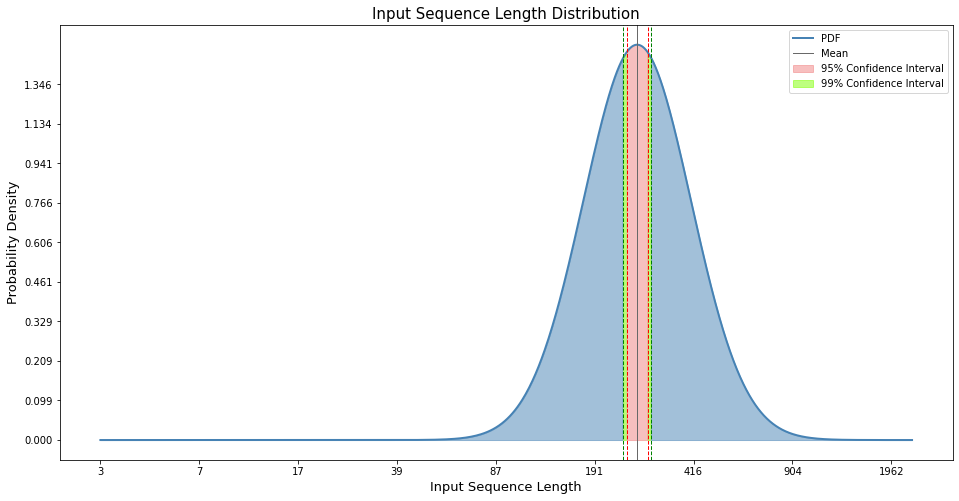

In [25]:
import scipy.stats as stats

plt.rcParams["figure.figsize"] = (16,8)

log_tok_dist = np.log1p(paper_token_dist)

log_token_max = np.max(log_tok_dist)
log_token_min = np.min(log_tok_dist)

log_token_var = np.var(log_tok_dist)
log_token_std = np.std(log_tok_dist)
log_token_mean = np.mean(log_tok_dist)

print("Token Distribution : {} ~ {}".format(min(paper_token_dist), max(paper_token_dist)))
print("Token Distribution Mean : {:.3f}\n".format(np.mean(paper_token_dist)))
print("Variance : {:.2f} \nStandard Devidation: {:.2f}\n".format(log_token_var, log_token_std))

x = sorted(log_tok_dist)
norm_dist = stats.norm(log_token_mean, log_token_std)

log_L_95 = log_token_mean - 1.96*(log_token_std/np.sqrt(100))
log_U_95 = log_token_mean + 1.96*(log_token_std/np.sqrt(100))
print("95% Confidence Interval : {:.2f} ~ {:.2f}".format(np.expm1(log_L_95), np.expm1(log_U_95)))

log_L_99 = log_token_mean - 2.58*(log_token_std/np.sqrt(100))
log_U_99 = log_token_mean + 2.58*(log_token_std/np.sqrt(100))
print("99% Confidence Interval : {:.2f} ~ {:.2f}".format(np.expm1(log_L_99), np.expm1(log_U_99)))

pdf_line, = plt.plot(x, norm_dist.pdf(x), color='steelblue', linewidth=2)

mean_line = plt.axvline(x=log_token_mean, color='dimgray', linewidth=1)

plt.axvline(log_L_95, color='r', linestyle='--', linewidth=1)
plt.axvline(log_U_95, color='r', linestyle='--', linewidth=1)

plt.axvline(log_L_99, color='g', linestyle='--', linewidth=1)
plt.axvline(log_U_99, color='g', linestyle='--', linewidth=1)

# plt.text(log_L_95-.1,.5,"{}".format(int(np.exp(log_L_95))), rotation=0)
# plt.text(log_U_95,.5,"{}".format(int(np.exp(log_U_95))), rotation=0)
# plt.text(log_token_mean +.02, .27,"{}".format(int(np.exp(log_token_mean))), rotation=0)

step = 0.01
plt.fill_between(np.arange(log_token_min, log_L_99, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_token_min , log_L_99, step=step)], alpha=0.5, color='steelblue') 

confidence_99_area = plt.fill_between(np.arange(log_L_99 , log_L_95, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_L_99 , log_L_95, step=step)], alpha=0.5, color='chartreuse')

confidence_area = plt.fill_between(np.arange(log_L_95 , log_U_95, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_L_95 , log_U_95, step=step)], alpha=0.5, color='lightcoral')

confidence_99_area = plt.fill_between(np.arange(log_U_95 , log_U_99, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_U_95 , log_U_99, step=step)], alpha=0.5, color='chartreuse')

plt.fill_between(np.arange(log_U_99 , log_token_max, step=step).tolist(), 
                 [norm_dist.pdf(i) for i in np.arange(log_U_99 , log_token_max, step=step)], alpha=0.5, color='steelblue') 

x_range = np.arange(log_token_min, log_token_max, step=log_token_max / 10).tolist()
x_range.sort()

plt.title("Input Sequence Length Distribution", fontsize=15)

plt.xticks(x_range, \
           ["{}".format(int(np.expm1(x))) for x in x_range])

y_range = np.arange(np.min(norm_dist.pdf(x)), np.max(norm_dist.pdf(x)), step=np.max(norm_dist.pdf(x)) / 10).tolist()

plt.yticks(y_range, \
           ["{:.3f}".format(np.expm1(y)) for y in y_range])
plt.xlabel('Input Sequence Length', fontsize=13)
plt.ylabel('Probability Density', fontsize=13)

plt.legend(handles=(pdf_line, mean_line, confidence_area, confidence_99_area), 
           labels=('PDF', "Mean", "95% Confidence Interval", "99% Confidence Interval"))


plt.show()

token 분포에 따라 데이터 정제  

In [26]:
len(dataset)

162341

In [27]:
refined_dataset = [data for data in dataset if len(data[-2]) >= 200 and len(data[-2]) < 300]
len(refined_dataset)

64409

In [28]:
import pandas as pd
refined_dataframe = pd.DataFrame(columns=['paper_id', 'content', 'summary', 'paper_token', 'summary_token'])

for data in refined_dataset:
    dic = {'paper_id' : data[0],
           'content' : data[1],
           'summary' : data[2],
           'paper_token' : data[3],
           'summary_token' : data[4]
          }
    refined_dataframe = refined_dataframe.append(dic, ignore_index=True)
    

In [29]:
refined_dataframe


,paper_id,content,summary,paper_token,summary_token
0,ART002387009,[본 연구는 박근혜 정부에서 추진되었던 한국사교과서 국정화에 대한 정책변동에 대한 ...,[본 논문은 박근혜 정부에서 추진되었던 한국사교과서 국정화에 대한 정책변동에 관한 ...,"[▁본, ▁연구, 는, ▁박근혜, ▁정부에서, ▁추진, 되었던, ▁한국, 사, 교과...","[▁본, ▁논, 문은, ▁박근혜, ▁정부에서, ▁추진, 되었던, ▁한국, 사, 교과..."
1,ART002387007,[본 연구는 고등학생들의 바른 인성함양을 위한 긍정적 태도 형성 프로그램의 효과를 ...,[본 논문은 고등학생들의 바른 인성함양을 위한 긍정적 태도 형성 프로그램의 효과를 ...,"[▁본, ▁연구, 는, ▁고등학생, 들의, ▁바른, ▁인, 성, 함, 양을, ▁위한...","[▁본, ▁논, 문은, ▁고등학생, 들의, ▁바른, ▁인, 성, 함, 양을, ▁위한..."
2,ART002389321,[새로 도입된 피지컬컴퓨팅 교육을 통해 학생들이 창의적으로 문제를 해결하거나 다양한...,[본 논문은 초·중등 학생들의 창의적 문제해결을 위한 피지컬컴퓨팅 수업 설계원리를 ...,"[▁새로, ▁도입, 된, ▁피, 지, 컬, 컴, 퓨, 팅, ▁교육을, ▁통해, ▁학...","[▁본, ▁논, 문은, ▁초·중, 등, ▁학생들의, ▁창의, 적, ▁문제, 해, 결..."
3,ART002387469,"[본 연구에서는 자아고갈 상태에서 냉압과제 수행동기가 통증반응(인내, 강도, 불쾌감...",[본 논문은 자아고갈 상태에서 냉압과제 수행동기가 통증반응에 미치는 영향을 검증하였...,"[▁본, ▁연구, 에서는, ▁자아, 고, 갈, ▁상태에서, ▁냉, 압, 과제, ▁수...","[▁본, ▁논, 문은, ▁자아, 고, 갈, ▁상태에서, ▁냉, 압, 과제, ▁수행,..."
4,ART002387478,"[본 연구는 외상 후 성장 이론을 바탕으로 침습적 반추, 정서조절방략 그리고 의도적...","[본 논문은 외상 후 성장 이론을 바탕으로 침습적 반추, 정서조절방략, 의도적 반추...","[▁본, ▁연구, 는, ▁외, 상, ▁후, ▁성장, ▁이, 론을, ▁바탕으로, ▁침...","[▁본, ▁논, 문은, ▁외, 상, ▁후, ▁성장, ▁이, 론을, ▁바탕으로, ▁침..."
...,...,...,...,...,...
64404,ART9001922702,"[휴대전화 전자파의 인체 유해성에 대한 국내외 관심이 고조됨에 따라, 우리 정부는 ...","[휴대전화 전자파의 인체 유해성에 대한 국내외 관심이 고조됨에 따라, 우리 정부는 ...","[▁휴대전화, ▁전자, 파의, ▁인, 체, ▁유해, 성에, ▁대한, ▁국내외, ▁관...","[▁휴대전화, ▁전자, 파의, ▁인, 체, ▁유해, 성에, ▁대한, ▁국내외, ▁관..."
64405,ART9001922913,[한나라를 건국한 고조 역시 무력으로 천하를 얻었기 때문에 무력에 의한 통치를 중시...,[한나라를 건국한 고조 역시 무력으로 천하를 얻었기에 무력에 의한 통치를 중시하고 ...,"[▁한나라, 를, ▁건국, 한, ▁고조, ▁역시, ▁무, 력으로, ▁천, 하를, ▁...","[▁한나라, 를, ▁건국, 한, ▁고조, ▁역시, ▁무, 력으로, ▁천, 하를, ▁..."
64406,ART9001922914,[현존하는 最古/最高의 한국 역사서 『三國史記』와 『三國遺事』에 대해 대립적으로 이...,[현존하는 最古/最高의 한국 역사서 『三國史記』와 『三國遺事』에 대해 대립적으로 이...,"[▁현, 존, 하는, ▁, 最, 古, /, 最, 高, 의, ▁한국, ▁역사, 서, ...","[▁현, 존, 하는, ▁, 最, 古, /, 最, 高, 의, ▁한국, ▁역사, 서, ..."
64407,ART9001922917,"[강(江)의 흐름은 시간과 공간을 초월하며, 강과 강 주변에 다양한 문화현상들을 형...","[본 논문에서는 홍천강 인근지역에 전승하는 ‘이괄설화’를 대상으로 했다., 이괄은 ...","[▁강, (, 江, )의, ▁흐름, 은, ▁시간과, ▁공간을, ▁초월, 하며,, ▁...","[▁본, ▁논문, 에서는, ▁홍, 천, 강, ▁인근, 지역에, ▁전, 승, 하는, ..."


In [31]:
refined_train_dataset = refined_dataframe[:38645]

In [32]:
refined_val_dataset = refined_dataframe[38645:51527]
refined_val_dataset

,paper_id,content,summary,paper_token,summary_token
38645,ART9001546699,"[기존의 FPGA기반 DES 전수조사 시스템은 비용대비 높은 성능을 가지고 있으나,...","[본고에서는 77개 Xilinx Virtex5-, LX50 FPGA로 구성된 상용 ...","[▁기존의, ▁F, PGA, 기반, ▁D, ES, ▁전수, 조사, ▁시스템, 은, ...","[▁본, 고, 에서는, ▁77, 개, ▁X, il, in, x, ▁V, ir, t,..."
38646,ART9001546704,[전력 분석 공격이 소개되면서 다양한 대응법들이 제안되었고 그러한 대응법들 중 블록...,"[본고에서는 이러한 단점을 보완하기 위해 마스킹 S-, box 테이블을 사용하지 않...","[▁전력, ▁분석, ▁공격, 이, ▁소개, 되면서, ▁다양한, ▁대응, 법, 들이,...","[▁본, 고, 에서는, ▁이러한, ▁단, 점을, ▁보완, 하기, ▁위해, ▁마, 스..."
38647,ART9001546960,"[폐광산에서는 지반침하 붕괴, 수질오염, 산림훼손 토양오염 등 지속적인 환경오염이 ...",[본 연구에서는 다양한 유형의 광해를 종합적으로 고려하여 광해방지사업의 편익을 산정...,"[▁폐, 광, 산, 에서는, ▁지, 반, 침, 하, ▁붕괴, ,, ▁수질, 오염, ...","[▁본, ▁연구, 에서는, ▁다양한, ▁유형, 의, ▁광, 해를, ▁종합적으로, ▁..."
38648,ART9001546980,"[본 연구에서는 광미층 상단에 강우침투 최소화, 산성침출수 발생억제와 황화광물 산화...","[이 연구에서는 광미층 상단에 강우침투 최소화, 산성침출수 발생억제와 황화광물 산화...","[▁본, ▁연구, 에서는, ▁광, 미, 층, ▁상, 단에, ▁강, 우, 침, 투, ...","[▁이, ▁연구, 에서는, ▁광, 미, 층, ▁상, 단에, ▁강, 우, 침, 투, ..."
38649,ART9001546985,[본 연구는 광산배수의 지구화학적 특성에 따른 광산배수 내 비소의 제거에 초점을 맞...,[이 연구는 광산배수의 지구화학적 특성에 따른 광산배수 내 비소의 제거에 초점을 맞...,"[▁본, ▁연구, 는, ▁광산, 배, 수의, ▁지구, 화, 학적, ▁특, 성에, ▁...","[▁이, ▁연구, 는, ▁광산, 배, 수의, ▁지구, 화, 학적, ▁특, 성에, ▁..."
...,...,...,...,...,...
51522,ART9001797395,"[파종기에 따른 울금의 초장, 경직경 및 엽수는 5월 10일파종구에서 가장 양호하였...",[생육단계에 따른 울금 지하경 무게 변화는 생육기간에경과함에 따라 지하경의 무게 증...,"[▁파, 종, 기에, ▁따른, ▁울, 금의, ▁초, 장,, ▁경, 직, 경, ▁및,...","[▁생, 육, 단계, 에, ▁따른, ▁울, 금, ▁지하, 경, ▁무게, ▁변화는, ..."
51523,ART9001797408,[관광 및 공연 등의 문화 사업은 서로 연계되어 발전해 왔고 최근 들어서 국내 K-...,"[이 논문은 센서네트워크에서 음성 및 데이터를 동시에 지원하는 TDMA MAC, 센...","[▁관광, ▁및, ▁공연, ▁등의, ▁문화, ▁사업은, ▁서로, ▁연계, 되어, ▁...","[▁이, ▁논, 문은, ▁센, 서, 네트워크, 에서, ▁음성, ▁및, ▁데이터를, ..."
51524,ART9001797412,[독도에 자생하는 벼과(Poaceae) 식물인 돌피(Echinochloa crus-...,[독도의 돌피와 물피를 포함한 조사된두 분류군은 유전자구간에서 동일한 염기서열을 나...,"[▁독, 도에, ▁자, 생, 하는, ▁벼, 과, (P, o, ac, ea, e), ...","[▁독, 도의, ▁돌, 피, 와, ▁물, 피를, ▁포함한, ▁조사, 된, 두, ▁분..."
51525,ART9001797424,"[본 연구는 남한강 유역의 관속식물을 조사하기 위해 수행되었다., 조사기간은 201...","[이 연구는 남한강 유역의 관속식물을 조사하기 위해 수행되었다., 귀화식물은 58분...","[▁본, ▁연구, 는, ▁남한, 강, ▁유, 역의, ▁관, 속, 식, 물을, ▁조사...","[▁이, ▁연구, 는, ▁남한, 강, ▁유, 역의, ▁관, 속, 식, 물을, ▁조사..."


In [35]:
refined_dev_dataset = refined_dataframe[:51527]
refined_dev_dataset

,paper_id,content,summary,paper_token,summary_token
0,ART002387009,[본 연구는 박근혜 정부에서 추진되었던 한국사교과서 국정화에 대한 정책변동에 대한 ...,[본 논문은 박근혜 정부에서 추진되었던 한국사교과서 국정화에 대한 정책변동에 관한 ...,"[▁본, ▁연구, 는, ▁박근혜, ▁정부에서, ▁추진, 되었던, ▁한국, 사, 교과...","[▁본, ▁논, 문은, ▁박근혜, ▁정부에서, ▁추진, 되었던, ▁한국, 사, 교과..."
1,ART002387007,[본 연구는 고등학생들의 바른 인성함양을 위한 긍정적 태도 형성 프로그램의 효과를 ...,[본 논문은 고등학생들의 바른 인성함양을 위한 긍정적 태도 형성 프로그램의 효과를 ...,"[▁본, ▁연구, 는, ▁고등학생, 들의, ▁바른, ▁인, 성, 함, 양을, ▁위한...","[▁본, ▁논, 문은, ▁고등학생, 들의, ▁바른, ▁인, 성, 함, 양을, ▁위한..."
2,ART002389321,[새로 도입된 피지컬컴퓨팅 교육을 통해 학생들이 창의적으로 문제를 해결하거나 다양한...,[본 논문은 초·중등 학생들의 창의적 문제해결을 위한 피지컬컴퓨팅 수업 설계원리를 ...,"[▁새로, ▁도입, 된, ▁피, 지, 컬, 컴, 퓨, 팅, ▁교육을, ▁통해, ▁학...","[▁본, ▁논, 문은, ▁초·중, 등, ▁학생들의, ▁창의, 적, ▁문제, 해, 결..."
3,ART002387469,"[본 연구에서는 자아고갈 상태에서 냉압과제 수행동기가 통증반응(인내, 강도, 불쾌감...",[본 논문은 자아고갈 상태에서 냉압과제 수행동기가 통증반응에 미치는 영향을 검증하였...,"[▁본, ▁연구, 에서는, ▁자아, 고, 갈, ▁상태에서, ▁냉, 압, 과제, ▁수...","[▁본, ▁논, 문은, ▁자아, 고, 갈, ▁상태에서, ▁냉, 압, 과제, ▁수행,..."
4,ART002387478,"[본 연구는 외상 후 성장 이론을 바탕으로 침습적 반추, 정서조절방략 그리고 의도적...","[본 논문은 외상 후 성장 이론을 바탕으로 침습적 반추, 정서조절방략, 의도적 반추...","[▁본, ▁연구, 는, ▁외, 상, ▁후, ▁성장, ▁이, 론을, ▁바탕으로, ▁침...","[▁본, ▁논, 문은, ▁외, 상, ▁후, ▁성장, ▁이, 론을, ▁바탕으로, ▁침..."
...,...,...,...,...,...
51522,ART9001797395,"[파종기에 따른 울금의 초장, 경직경 및 엽수는 5월 10일파종구에서 가장 양호하였...",[생육단계에 따른 울금 지하경 무게 변화는 생육기간에경과함에 따라 지하경의 무게 증...,"[▁파, 종, 기에, ▁따른, ▁울, 금의, ▁초, 장,, ▁경, 직, 경, ▁및,...","[▁생, 육, 단계, 에, ▁따른, ▁울, 금, ▁지하, 경, ▁무게, ▁변화는, ..."
51523,ART9001797408,[관광 및 공연 등의 문화 사업은 서로 연계되어 발전해 왔고 최근 들어서 국내 K-...,"[이 논문은 센서네트워크에서 음성 및 데이터를 동시에 지원하는 TDMA MAC, 센...","[▁관광, ▁및, ▁공연, ▁등의, ▁문화, ▁사업은, ▁서로, ▁연계, 되어, ▁...","[▁이, ▁논, 문은, ▁센, 서, 네트워크, 에서, ▁음성, ▁및, ▁데이터를, ..."
51524,ART9001797412,[독도에 자생하는 벼과(Poaceae) 식물인 돌피(Echinochloa crus-...,[독도의 돌피와 물피를 포함한 조사된두 분류군은 유전자구간에서 동일한 염기서열을 나...,"[▁독, 도에, ▁자, 생, 하는, ▁벼, 과, (P, o, ac, ea, e), ...","[▁독, 도의, ▁돌, 피, 와, ▁물, 피를, ▁포함한, ▁조사, 된, 두, ▁분..."
51525,ART9001797424,"[본 연구는 남한강 유역의 관속식물을 조사하기 위해 수행되었다., 조사기간은 201...","[이 연구는 남한강 유역의 관속식물을 조사하기 위해 수행되었다., 귀화식물은 58분...","[▁본, ▁연구, 는, ▁남한, 강, ▁유, 역의, ▁관, 속, 식, 물을, ▁조사...","[▁이, ▁연구, 는, ▁남한, 강, ▁유, 역의, ▁관, 속, 식, 물을, ▁조사..."


In [33]:
refined_test_dataset = refined_dataframe[51527:]
refined_test_dataset

,paper_id,content,summary,paper_token,summary_token
51527,ART9001797454,[좀비비추 ‘White Edge’는 돌연변이 유기용 화학물질인EMS(ethyle m...,[좀비비추 ‘White Edge’는 돌연변이 유기용 화학물질인EMS용액을 이용해 돌...,"[▁좀, 비, 비, 추, ▁‘, W, h, it, e, ▁E, d, g, e, ’는...","[▁좀, 비, 비, 추, ▁‘, W, h, it, e, ▁E, d, g, e, ’는..."
51528,ART9001797508,"[윤리학의 뿌리 깊은 논쟁 중의 하나는 도덕의 본질이 무엇이냐는 것이다., 윤리학의...","[윤리학의 뿌리 깊은 논쟁 중의 하나는 도덕의 본질이 무엇이냐는 것이다., 본 연구...","[▁윤리, 학의, ▁뿌리, ▁깊은, ▁논쟁, ▁중의, ▁하나는, ▁도덕, 의, ▁본...","[▁윤리, 학의, ▁뿌리, ▁깊은, ▁논쟁, ▁중의, ▁하나는, ▁도덕, 의, ▁본..."
51529,ART9001797510,"[급속한 정치적 재통일 후 20년, 실질적으로 통일이 이루어졌다는 점에 동의하는 사...",[본 연구의 주된 목적은 독일인들이 어디에서 시행착오를 가져왔는지 구조 전환과정에서...,"[▁급, 속한, ▁정치적, ▁재, 통일, ▁후, ▁20년, ,, ▁실질적으로, ▁통...","[▁본, ▁연구, 의, ▁주된, ▁목적은, ▁독일, 인들이, ▁어디, 에서, ▁시행..."
51530,ART9001797588,[본 연구에서는 율곡과 다산의 교육사상을 비교·분석해봄으로써 이들의 교육사상이 현대...,[이 연구에서는 율곡과 다산의 교육사상을 비교·분석해봄으로써 이들의 교육사상이 현대...,"[▁본, ▁연구, 에서는, ▁율, 곡, 과, ▁다, 산의, ▁교육, 사, 상을, ▁...","[▁이, ▁연구, 에서는, ▁율, 곡, 과, ▁다, 산의, ▁교육, 사, 상을, ▁..."
51531,ART9001797595,[본 연구는 미국 캘리포니아주에 소재한 대학교에 재학 중인 대학생을 중심으로 신체활...,[이 연구는 미국 캘리포니아주에 소재한 대학교에 재학 중인 대학생을 중심으로 신체활...,"[▁본, ▁연구, 는, ▁미국, ▁캘리포니아, 주에, ▁소재, 한, ▁대학교, 에,...","[▁이, ▁연구, 는, ▁미국, ▁캘리포니아, 주에, ▁소재, 한, ▁대학교, 에,..."
...,...,...,...,...,...
64404,ART9001922702,"[휴대전화 전자파의 인체 유해성에 대한 국내외 관심이 고조됨에 따라, 우리 정부는 ...","[휴대전화 전자파의 인체 유해성에 대한 국내외 관심이 고조됨에 따라, 우리 정부는 ...","[▁휴대전화, ▁전자, 파의, ▁인, 체, ▁유해, 성에, ▁대한, ▁국내외, ▁관...","[▁휴대전화, ▁전자, 파의, ▁인, 체, ▁유해, 성에, ▁대한, ▁국내외, ▁관..."
64405,ART9001922913,[한나라를 건국한 고조 역시 무력으로 천하를 얻었기 때문에 무력에 의한 통치를 중시...,[한나라를 건국한 고조 역시 무력으로 천하를 얻었기에 무력에 의한 통치를 중시하고 ...,"[▁한나라, 를, ▁건국, 한, ▁고조, ▁역시, ▁무, 력으로, ▁천, 하를, ▁...","[▁한나라, 를, ▁건국, 한, ▁고조, ▁역시, ▁무, 력으로, ▁천, 하를, ▁..."
64406,ART9001922914,[현존하는 最古/最高의 한국 역사서 『三國史記』와 『三國遺事』에 대해 대립적으로 이...,[현존하는 最古/最高의 한국 역사서 『三國史記』와 『三國遺事』에 대해 대립적으로 이...,"[▁현, 존, 하는, ▁, 最, 古, /, 最, 高, 의, ▁한국, ▁역사, 서, ...","[▁현, 존, 하는, ▁, 最, 古, /, 最, 高, 의, ▁한국, ▁역사, 서, ..."
64407,ART9001922917,"[강(江)의 흐름은 시간과 공간을 초월하며, 강과 강 주변에 다양한 문화현상들을 형...","[본 논문에서는 홍천강 인근지역에 전승하는 ‘이괄설화’를 대상으로 했다., 이괄은 ...","[▁강, (, 江, )의, ▁흐름, 은, ▁시간과, ▁공간을, ▁초월, 하며,, ▁...","[▁본, ▁논문, 에서는, ▁홍, 천, 강, ▁인근, 지역에, ▁전, 승, 하는, ..."


In [36]:
import pickle

mkdir_p(kor_bart_data_dir)
train_idx_filepath = pjoin(kor_bart_data_dir, 'train_data_idx.txt')
test_idx_filepath = pjoin(kor_bart_data_dir, 'test_data_idx.txt')

print(train_idx_filepath)
with open(train_idx_filepath, 'wb') as f:
    pickle.dump([data[0] for _, data in refined_dev_dataset.iterrows()], f)
    
print(test_idx_filepath)
with open(test_idx_filepath, 'wb') as f:
    pickle.dump([data[0] for _, data in refined_test_dataset.iterrows()], f)

/data/ksb/BART/KoBART-summarization/paper_data/train_data_idx.txt
/data/ksb/BART/KoBART-summarization/paper_data/test_data_idx.txt


In [37]:
train_idx_filepath = pjoin(kor_bart_data_dir, 'train_data_idx.txt')
valid_idx_filepath = pjoin(kor_bart_data_dir, 'val_data_idx.txt')

In [38]:
import pickle
with open(train_idx_filepath, 'rb') as f:
    tmp = pickle.load(f)
len(tmp)

51527

In [39]:
save_train_data = refined_train_dataset.drop(['paper_id', 'paper_token', 'summary_token'], axis=1)
save_train_data

,content,summary
0,[본 연구는 박근혜 정부에서 추진되었던 한국사교과서 국정화에 대한 정책변동에 대한 ...,[본 논문은 박근혜 정부에서 추진되었던 한국사교과서 국정화에 대한 정책변동에 관한 ...
1,[본 연구는 고등학생들의 바른 인성함양을 위한 긍정적 태도 형성 프로그램의 효과를 ...,[본 논문은 고등학생들의 바른 인성함양을 위한 긍정적 태도 형성 프로그램의 효과를 ...
2,[새로 도입된 피지컬컴퓨팅 교육을 통해 학생들이 창의적으로 문제를 해결하거나 다양한...,[본 논문은 초·중등 학생들의 창의적 문제해결을 위한 피지컬컴퓨팅 수업 설계원리를 ...
3,"[본 연구에서는 자아고갈 상태에서 냉압과제 수행동기가 통증반응(인내, 강도, 불쾌감...",[본 논문은 자아고갈 상태에서 냉압과제 수행동기가 통증반응에 미치는 영향을 검증하였...
4,"[본 연구는 외상 후 성장 이론을 바탕으로 침습적 반추, 정서조절방략 그리고 의도적...","[본 논문은 외상 후 성장 이론을 바탕으로 침습적 반추, 정서조절방략, 의도적 반추..."
...,...,...
38640,[바이오인식 기술을 이용한 사용자 인증은 편리함과 동시에 강력한 보안성을 제공하는 ...,"[본고에서는 거짓특징점을 임의로 추가하지 않고 특징점의 좌표, 방향 등 진짜특징점의..."
38641,[네트워크 및 컴퓨터의 발전에 따라 악성코드 역시 폭발적인 증가 추이를 보이고 있으...,"[변종 및 신종 악성코드를 빠르게 탐지하기 위해, 본 연구에서는 행위 그래프 분석을..."
38642,"[최근 타원곡선 상에서의 페어링은 ID 기반의 암호/서명/인증/키공유 기법, 등 다...",[본고에서는 EtaT 페어링 알고리즘에서 제안된 RVA 기반의 부채널 대응방법의 취...
38643,[최근 Application에 대한 공격을 통하여 네트워크와 데이터베이스에 대한 방...,[본고에서는 침입탐지 룰을 설정한 Application에 대한 공격을 차단하기 위한...


In [40]:
save_train_data = save_train_data.rename(columns={"content": "news"})
save_train_data

,news,summary
0,[본 연구는 박근혜 정부에서 추진되었던 한국사교과서 국정화에 대한 정책변동에 대한 ...,[본 논문은 박근혜 정부에서 추진되었던 한국사교과서 국정화에 대한 정책변동에 관한 ...
1,[본 연구는 고등학생들의 바른 인성함양을 위한 긍정적 태도 형성 프로그램의 효과를 ...,[본 논문은 고등학생들의 바른 인성함양을 위한 긍정적 태도 형성 프로그램의 효과를 ...
2,[새로 도입된 피지컬컴퓨팅 교육을 통해 학생들이 창의적으로 문제를 해결하거나 다양한...,[본 논문은 초·중등 학생들의 창의적 문제해결을 위한 피지컬컴퓨팅 수업 설계원리를 ...
3,"[본 연구에서는 자아고갈 상태에서 냉압과제 수행동기가 통증반응(인내, 강도, 불쾌감...",[본 논문은 자아고갈 상태에서 냉압과제 수행동기가 통증반응에 미치는 영향을 검증하였...
4,"[본 연구는 외상 후 성장 이론을 바탕으로 침습적 반추, 정서조절방략 그리고 의도적...","[본 논문은 외상 후 성장 이론을 바탕으로 침습적 반추, 정서조절방략, 의도적 반추..."
...,...,...
38640,[바이오인식 기술을 이용한 사용자 인증은 편리함과 동시에 강력한 보안성을 제공하는 ...,"[본고에서는 거짓특징점을 임의로 추가하지 않고 특징점의 좌표, 방향 등 진짜특징점의..."
38641,[네트워크 및 컴퓨터의 발전에 따라 악성코드 역시 폭발적인 증가 추이를 보이고 있으...,"[변종 및 신종 악성코드를 빠르게 탐지하기 위해, 본 연구에서는 행위 그래프 분석을..."
38642,"[최근 타원곡선 상에서의 페어링은 ID 기반의 암호/서명/인증/키공유 기법, 등 다...",[본고에서는 EtaT 페어링 알고리즘에서 제안된 RVA 기반의 부채널 대응방법의 취...
38643,[최근 Application에 대한 공격을 통하여 네트워크와 데이터베이스에 대한 방...,[본고에서는 침입탐지 룰을 설정한 Application에 대한 공격을 차단하기 위한...


In [41]:
train_data_path

'/data/ksb/BART/KoBART-summarization/paper_data/train.tsv'

In [42]:
save_train_data.to_csv(train_data_path, columns=['news','summary'], sep='\t', index=False)

In [44]:
save_test_data = refined_test_dataset.drop(['paper_id', 'paper_token', 'summary_token'], axis=1)
save_test_data = save_test_data.rename(columns={"content": "news"})
save_test_data

,news,summary
51527,[좀비비추 ‘White Edge’는 돌연변이 유기용 화학물질인EMS(ethyle m...,[좀비비추 ‘White Edge’는 돌연변이 유기용 화학물질인EMS용액을 이용해 돌...
51528,"[윤리학의 뿌리 깊은 논쟁 중의 하나는 도덕의 본질이 무엇이냐는 것이다., 윤리학의...","[윤리학의 뿌리 깊은 논쟁 중의 하나는 도덕의 본질이 무엇이냐는 것이다., 본 연구..."
51529,"[급속한 정치적 재통일 후 20년, 실질적으로 통일이 이루어졌다는 점에 동의하는 사...",[본 연구의 주된 목적은 독일인들이 어디에서 시행착오를 가져왔는지 구조 전환과정에서...
51530,[본 연구에서는 율곡과 다산의 교육사상을 비교·분석해봄으로써 이들의 교육사상이 현대...,[이 연구에서는 율곡과 다산의 교육사상을 비교·분석해봄으로써 이들의 교육사상이 현대...
51531,[본 연구는 미국 캘리포니아주에 소재한 대학교에 재학 중인 대학생을 중심으로 신체활...,[이 연구는 미국 캘리포니아주에 소재한 대학교에 재학 중인 대학생을 중심으로 신체활...
...,...,...
64404,"[휴대전화 전자파의 인체 유해성에 대한 국내외 관심이 고조됨에 따라, 우리 정부는 ...","[휴대전화 전자파의 인체 유해성에 대한 국내외 관심이 고조됨에 따라, 우리 정부는 ..."
64405,[한나라를 건국한 고조 역시 무력으로 천하를 얻었기 때문에 무력에 의한 통치를 중시...,[한나라를 건국한 고조 역시 무력으로 천하를 얻었기에 무력에 의한 통치를 중시하고 ...
64406,[현존하는 最古/最高의 한국 역사서 『三國史記』와 『三國遺事』에 대해 대립적으로 이...,[현존하는 最古/最高의 한국 역사서 『三國史記』와 『三國遺事』에 대해 대립적으로 이...
64407,"[강(江)의 흐름은 시간과 공간을 초월하며, 강과 강 주변에 다양한 문화현상들을 형...","[본 논문에서는 홍천강 인근지역에 전승하는 ‘이괄설화’를 대상으로 했다., 이괄은 ..."


In [45]:
test_data_path

'/data/ksb/BART/KoBART-summarization/paper_data/test.tsv'

In [46]:
save_test_data.to_csv(test_data_path, columns=['news','summary'], sep='\t', index=False)

### BERT Extractor

In [47]:
import pickle

train_idx_filepath = pjoin(kor_bart_data_dir, 'train_data_idx.txt')
test_idx_filepath = pjoin(kor_bart_data_dir, 'test_data_idx.txt')

print(train_idx_filepath)
with open(train_idx_filepath, 'rb') as f:
    train_news_ids = pickle.load(f)
    
print(test_idx_filepath)
with open(test_idx_filepath, 'rb') as f:
    test_news_ids = pickle.load(f)

/data/ksb/BART/KoBART-summarization/paper_data/train_data_idx.txt
/data/ksb/BART/KoBART-summarization/paper_data/test_data_idx.txt


In [48]:
valid_news_ids = train_news_ids[-12882:]
train_news_ids = train_news_ids[:-12882]

In [49]:
len(train_news_ids)

38645

In [50]:
train_news_ids[0]

'ART002387009'

In [51]:
assert len(train_news_ids) == 38645
assert len(valid_news_ids) == 12882
assert len(test_news_ids) == 12882

In [52]:
kobert_mapping_data = pjoin(kobert_root, 'paper_urls')
kobert_mapping_data

'/data/ksb/BertSum/koBertSum/paper_urls'

In [53]:
mkdir_p(kobert_mapping_data)

In [54]:
bert_train_idx_filepath = pjoin(kobert_mapping_data, 'train_data_idx.txt')
bert_val_idx_filepath = pjoin(kobert_mapping_data, 'valid_data_idx.txt')
bert_test_idx_filepath = pjoin(kobert_mapping_data, 'test_data_idx.txt')

print(bert_train_idx_filepath)
with open(bert_train_idx_filepath, 'wb') as f:
    pickle.dump([idx for idx in train_news_ids], f)
    
print(bert_val_idx_filepath)
with open(bert_val_idx_filepath, 'wb') as f:
    pickle.dump([idx for idx in valid_news_ids], f)
    
print(bert_test_idx_filepath)
with open(bert_test_idx_filepath, 'wb') as f:
    pickle.dump([idx for idx in test_news_ids], f)

/data/ksb/BertSum/koBertSum/paper_urls/train_data_idx.txt
/data/ksb/BertSum/koBertSum/paper_urls/valid_data_idx.txt
/data/ksb/BertSum/koBertSum/paper_urls/test_data_idx.txt


In [55]:
def get_mapping_list(reg_exp, mapping_list):
    
    paper_list = []
    
    for path in iglob(reg_exp, recursive=False):
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            for paper in data['data']:
                idx = paper['reg_no']
                
                if not idx in mapping_list:
                    continue

                entire_paper = paper['summary_entire'][0]
               
                content = entire_paper['orginal_text']
                content = list(split_doc(content))
                abs_summ = entire_paper['summary_text']
                abs_summ = list(split_doc(abs_summ))
                
                paper_dic = (idx, content, abs_summ)
                paper_list.append(paper_dic)
        
    return paper_list
    

In [56]:
train_data = pjoin(data_root, 'train_paper_*.json')
val_data = pjoin(data_root,'valid_paper_*.json')

In [57]:
train_data

'/data/ksb/korean_paper/train_paper_*.json'

In [58]:
bert_train_list = get_mapping_list(train_data, train_news_ids)
bert_train_list += get_mapping_list(val_data, train_news_ids)

In [59]:
bert_valid_list = get_mapping_list(train_data, valid_news_ids)
bert_valid_list += get_mapping_list(val_data, valid_news_ids)

In [60]:
bert_test_list = get_mapping_list(train_data, test_news_ids)
bert_test_list += get_mapping_list(val_data, test_news_ids)

In [61]:
assert len(train_news_ids) == 38645
assert len(valid_news_ids) == 12882
assert len(test_news_ids) == 12882

In [62]:
bert_train_list[0][1]

['본 연구는 박근혜 정부에서 추진되었던 한국사교과서 국정화에 대한 정책변동에 대한 분석과 정책적 제안을 목적으로 한다.',
 '한국사교과서 발행체제가검정제와 국정제의 순환적 변동을 하였는데, 이러한 과정을 분석하기 위해다중흐름모형을 활용하였다.',
 '분석의 결과, 정책문제의 흐름은 한국사교과서의 내용에 관한 논란에서 국정제교과서 발행체제의 문제로 성격이 변하였다.',
 '따라서 시행규칙만으로 간단히 바꿀 수 있는 현행 제도를 강화해야 할 필요성이 있다.',
 '그리고 정치의흐름과 관련하여 보면 집권세력의 변동에 따라 정책의 변동이 생길 수 있으며, 반대집단이 우세한 국가적 분위기에서 정책의 일관성은 유지될 수 없는것으로 분석되었다.',
 '따라서 다양한 의견을 반영할 수 있는 정책적 고려가 필요하다.',
 '한편, 정책대안의 흐름은 대안의 제시와 이익집단의 활동 모두에서반대의 기류가 강했지만 청와대와 교육부는 강행으로 나타났다.',
 '특히 이념적지향에 따라 정책의 창이 의해 열리고 닫히는 한국사교과서 발행제의 경우는교육의 정치적 중립성을 지닌 정책혁신가의 역할이 중요하다.']

In [63]:
bert_train_list[11][2]

['본 논문에서는 성격강점이 자연발생적으로 어떤 군집을 형성하는지 한국 성인을 대상으로 탐색하고, 분류된 군집에 따른 행복과 우울의 차이와 인구사회학적 변인의 특성을 연구하였다.',
 '군집분석을 통하여 만 20세 이상 827명의 참여자를 5개 집단으로 나누었다.']

In [64]:
abstrac_inf = '@highlight\n\n'

In [65]:
kobert_data

'/data/ksb/BertSum/koBertSum/kopaper_raw_stories'

In [66]:
mkdir_p(kobert_data)

In [68]:
bert_data = bert_train_list + bert_valid_list + bert_test_list

for data in bert_data:
    
    news_id = data[0]
    article = data[1]
    abs_summ = data[2]
        
    article = list(map(lambda line: line + '\n\n',article))
    abs_summ = list(map(lambda line: abstrac_inf + line + '\n\n',abs_summ))
    
    file_name = os.path.join(kobert_data, str(news_id)+".story")    
    with open(file_name, 'w', encoding='utf-8') as f_s:
        f_s.writelines(article)
        f_s.writelines(abs_summ)

In [69]:
from functools import reduce
with open(pjoin(kobert_data, 'ART002387007.story'), 'r', encoding='utf-8') as f:
    l = f.readlines()
    txt = reduce(lambda x, y: x+y, l)
    print(txt)

본 연구는 고등학생들의 바른 인성함양을 위한 긍정적 태도 형성 프로그램의 효과를 알아보기 위해 연구를 수행하였다.

이를 위해 자아에 대한 긍정적 태도형성 프로그램의 구안·적용은 경기도소재 00고등학교 1학년0반 학생37명(남학생 21명, 여학생 16명)을 대상으로 현장 답사 및 사전·사후 설문조사를 실시하였다.

분석 결과 다양한 인성교육 프로그램의 활동을 통하여 다음과 같은 결론을 얻을 수 있었다.

첫째, 학생들이 올바른 가치판단을 위한 체험적 동기를부여한 결과 바른 행동으로 실천하려는 경향을 보였다.

둘째, 고운 심성가꾸기를 통한 인성교육과 관련된 다양한 환경 구성으로 인해 학생들의 고운 마음과 올바른 행동이 가시적으로 나타났다.

셋째, 다양한 체험위주의 학습활동으로 학생들의 창의력이 신장되었다.

넷째, 공동체 의식 함양 프로그램의 적용으로 협동심이 배양되고, 가정과 사회 윤리의식을 인식하고 실천하는 계기가 되었다.

다섯째, 다양한 시상제로 긍정적인 행동이 강화되고 고운 심성을실천하는 풍토가 조성되었다.

한편, 바람직한 학교인성교육을 위해 실천위주의 체험적인 인성교육이 이루어져야 하며, 아울러 인성교육의 효과는 짧은시간에 가시적으로 나타나는 것이 아니므로 지속적이고 영속적으로 이루어져야 한다.

@highlight

본 논문은 고등학생들의 바른 인성함양을 위한 긍정적 태도 형성 프로그램의 효과를 알아보기 위하여 연구를 진행하였다.

@highlight

자아에 대한 긍정적 태도형성 프로그램의 구안·적용은 경기도소재 고등학교 1학년 학생 37명을 대상으로 현장 답사와 사전·사후 설문조사를 진행하였다.




### MatchSum

In [ ]:
def get_result_list(src_regex):
    gold, cand, cand_num, src = [], [], [], []

    for file_paths in iglob(src_regex, recursive=False):
        lines = []
        with open(file_paths) as f:
            lines = f.readlines()

        if file_paths.endswith('gold'):
            gold = lines
        elif file_paths.endswith('candidate_sent_num'):
            cand_num = lines
        elif file_paths.endswith('candidate'):
            cand = lines
        elif file_paths.endswith('src'):
            src = lines
        else:
            print(file_paths)
            raise ValueError
    
    return src, gold, cand, cand_num
    

In [ ]:
src, gold, cand, cand_num = get_result_list(join(bert_result, 'candidate_5_*'))

print("gold len : {}".format(len(gold)))
print("src len : {}".format(len(src)))
print("cand len : {}".format(len(cand)))
print("cand_num len : {}".format(len(cand_num)))

In [ ]:
assert len(gold)==len(src) and len(src)==len(cand) and len(cand_num)==len(cand)

In [ ]:
match_json_data = os.path.join(root_dir,'origin')

del_folder(origin_dir)
mkdir_p(origin_dir)

In [ ]:
origin_json_file = os.path.join(origin_dir, 'origin_data.jsonl')

with open(origin_json_file, 'w', encoding='utf-8') as f:
    writer = jsonlines.Writer(f)
    for _gold, _cand, _src in zip(gold, cand, src):

        src_list = _src.split(split_symbol)
        src_list = list(map(lambda txt : txt.replace('\n',''), src_list))

        abs_list = _gold.split(split_symbol)
        abs_list = list(map(lambda txt : txt.replace('\n',''), abs_list))

        d = {"text" : src_list, "summary" : abs_list}

        writer.write(d) 

In [ ]:
index_json_file = os.path.join(origin_dir, 'index.jsonl')

with open(index_json_file, 'w', encoding='utf-8') as f:
    writer = jsonlines.Writer(f)
    for _cand_num in cand_num:
        
        idx_list = _cand_num.split(split_symbol)
        idx_list = [int(idx.replace('\n','')) for idx in idx_list]
        idx_json = {"sent_id" : idx_list}
        
        writer.write(idx_json)

### RefSum

In [119]:
ref_mapping_data = pjoin(kobert_root, 'ref_urls')
ref_mapping_data

'/data/ksb/BertSum/koBertSum/ref_urls'

In [120]:
import pickle

train_idx_filepath = pjoin(kor_bart_data_dir, 'train_data_idx.txt')
test_idx_filepath = pjoin(kor_bart_data_dir, 'test_data_idx.txt')

print(train_idx_filepath)
with open(train_idx_filepath, 'rb') as f:
    train_news_ids = pickle.load(f)
    
print(test_idx_filepath)
with open(test_idx_filepath, 'rb') as f:
    test_news_ids = pickle.load(f)

/data/ksb/BART/KoBART-summarization/data/train_data_idx.txt
/data/ksb/BART/KoBART-summarization/data/test_data_idx.txt


In [121]:
import random

news_ids = train_news_ids + test_news_ids
random.shuffle(news_ids) 

train_news_ids = news_ids[:25000]
valid_news_ids = news_ids[25000:30000]
test_news_ids = news_ids[30000:]

In [123]:
ref_train_idx_filepath = pjoin(ref_mapping_data, 'train_data_idx.txt')
ref_val_idx_filepath = pjoin(ref_mapping_data, 'valid_data_idx.txt')
ref_test_idx_filepath = pjoin(ref_mapping_data, 'test_data_idx.txt')

mkdir_p(ref_mapping_data)
print(ref_train_idx_filepath)
with open(ref_train_idx_filepath, 'wb') as f:
    pickle.dump([idx for idx in train_news_ids], f)
    
print(ref_val_idx_filepath)
with open(ref_val_idx_filepath, 'wb') as f:
    pickle.dump([idx for idx in valid_news_ids], f)
    
print(ref_test_idx_filepath)
with open(ref_test_idx_filepath, 'wb') as f:
    pickle.dump([idx for idx in test_news_ids], f)

/data/ksb/BertSum/koBertSum/ref_urls/train_data_idx.txt
/data/ksb/BertSum/koBertSum/ref_urls/valid_data_idx.txt
/data/ksb/BertSum/koBertSum/ref_urls/test_data_idx.txt
